# 串联模型

In [35]:
import numpy as np
import pandas as pd
import pymssql
import csv
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

file = pd.read_csv('C:/Users/admin/Desktop/csv/G_Data0000000683.csv')
sql_source = pd.DataFrame(file)
###########################################
sql_source.CreateDate = sql_source.CreateDate.astype('datetime64')
############################################
target = pd.DataFrame(columns = ['date','T','use_gas_day'])
i = 0
j = 0
while i<len(sql_source)-1:
    while(i+1<len(sql_source) and sql_source.at[i,'CreateDate'].date()==sql_source.at[i+1,'CreateDate'].date()):
        i = i+1
    j = i+1
    while(j+1<len(sql_source) and sql_source.at[j,'CreateDate'].date()==sql_source.at[j+1,'CreateDate'].date()):
        j = j+1
    if(sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']<0):
        break
    if((sql_source.at[j,'CreateDate'].date()-sql_source.at[i,'CreateDate'].date()).days==1 and sql_source.at[i,'CreateDate'].hour==sql_source.at[j,'CreateDate'].hour and 30>=abs(sql_source.at[i,'CreateDate'].minute-sql_source.at[j,'CreateDate'].minute)>=0 and sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']>0):
        target = target.append([{'date':sql_source.at[j,'CreateDate'].date(),'T':sql_source.at[j,'T'],'use_gas_day':sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']}],ignore_index = True)
    i = j
##############################################
i = 1
while i<len(target)-1:
    a = target.at[i-1,'use_gas_day']
    b = target.at[i,'use_gas_day']
    c = target.at[i+1,'use_gas_day']
    A = abs(b-a)/max(a,b)
    B = abs(c-b)/max(c,b)
    if(A>0.5 and B>0.5):
        target.at[i,'use_gas_day'] = (a+c)/2
    i = i+1
# Covnert date column to 时间戳Index
target = target.reset_index(drop=True).set_index('date')
target.index = pd.DatetimeIndex(target.index)
target = target.groupby('date')['T','use_gas_day'].sum().reset_index()
target = target.set_index('date')
########################################
import matplotlib.pyplot as plt

#补全日期
target = target.resample('D').mean()
target = target.fillna(target.bfill())
print(len(target))

y = target['use_gas_day']

y_T = target['T']

1075


In [20]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
#pdq = list(itertools.product(p, d, q))
#pdq = [(1,1,1)]
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[4]))


# Iterate a GridSearch function to test different parameters of seasonal ARIMA models 
import warnings 

warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
#                                             exog = y_T,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:18824.044490940953
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:17774.47975335205
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:16698.869887395103
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:16442.946448326627
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:16671.45011153582
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:16603.144936992816
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:16458.35609941113
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:16443.135997860194
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:17666.88337453785
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:16851.94934897432
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:16163.010406079105
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:15837.97452109966
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:16125.90169462216
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:15989.574978391585
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:15887.058376528534


### Min_AIC_list ### 
param                 (1, 1, 1)
param_seasonal    (0, 1, 1, 12)
AIC                     15040.3
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3148      0.040      7.890      0.000       0.237       0.393
ma.L1         -0.6702      0.034    -19.795      0.000      -0.737      -0.604
sigma2      9.525e+04   1743.101     54.643      0.000    9.18e+04    9.87e+04


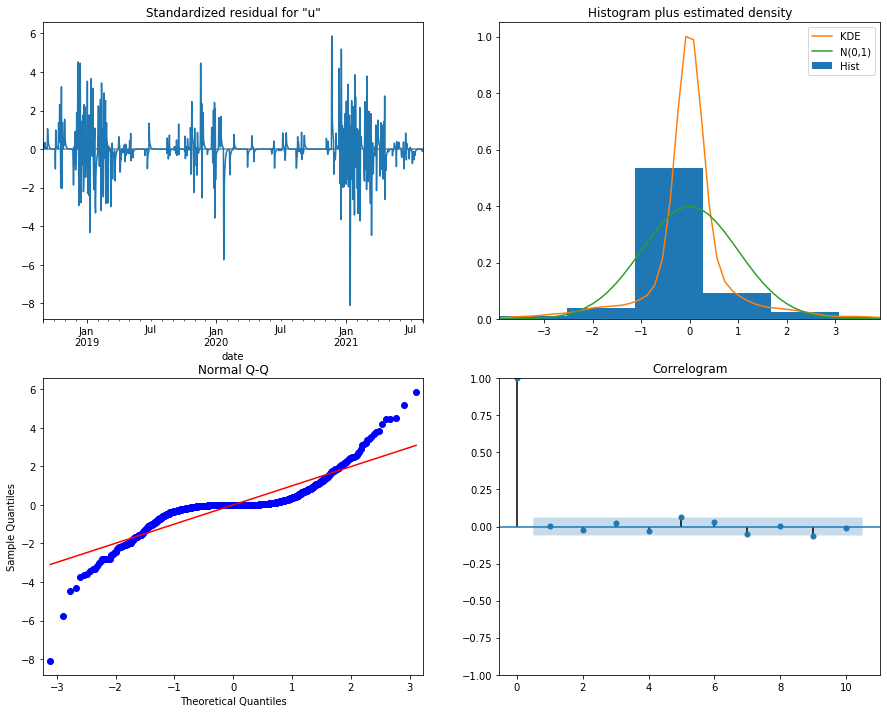

In [36]:
print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

mod = sm.tsa.statespace.SARIMAX(y,
#                                 exog = y_T,
                                order=Min_AIC_list.param,
                               # seasonal_order=Min_AIC_list.param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

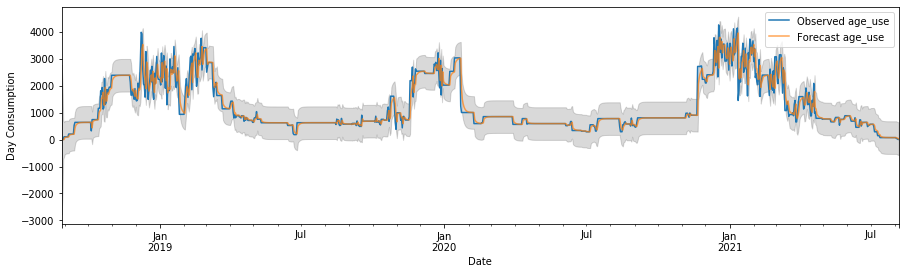

In [38]:
pred = results.get_prediction(start = pd.to_datetime('2018-8-28'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2018-8-28':].plot(label = 'Observed age_use')
pred.predicted_mean.plot(ax=ax, label='Forecast age_use', alpha=.7, figsize=(15, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha= 0.15)

ax.set_xlabel('Date')
ax.set_ylabel('Day Consumption')
plt.legend()

plt.show()

In [39]:
y_forecasted = pred.predicted_mean
y_forecasted = y_forecasted.shift(-1)
target = target.loc[:,['use_gas_day','T']]
y_forecasted[len(y_forecasted)-1] = y[len(y)-1]
target['y_forecasted'] = y_forecasted

#归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
target['y_forecasted'] = scaler.fit_transform(target.iloc[:, 2:3])
target['T'] = scaler.fit_transform(target.iloc[:, 1:2])
target['use_gas_day'] = scaler.fit_transform(target.iloc[:, 0:1])
print(target)

            use_gas_day         T  y_forecasted
date                                           
2018-08-28     0.000000  0.672139      0.000000
2018-08-29     0.000058  0.685820      0.000067
2018-08-30     0.000058  0.685820      0.000058
2018-08-31     0.023938  0.684452      0.018608
2018-09-01     0.023938  0.684452      0.021196
...                 ...       ...           ...
2021-08-02     0.016971  0.666669      0.018247
2021-08-03     0.008998  1.000000      0.012717
2021-08-04     0.008998  1.000000      0.011711
2021-08-05     0.001025  0.883687      0.005508
2021-08-06     0.001025  0.883687      0.001091

[1075 rows x 3 columns]


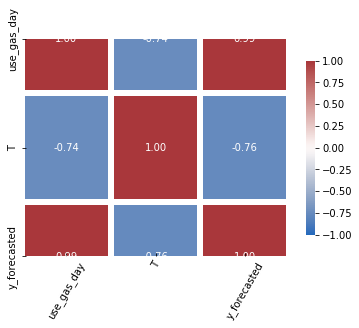

In [40]:
# builds a correlation matrix for the z-scored columns
target_cor = target.corr()
import seaborn as sns
import matplotlib.pyplot as plt
# creates the figure and axis for the subplots
fig, ax = plt.subplots(figsize=(6, 4))

# plots heatmap
sns_plt = sns.heatmap(target_cor, annot=True, fmt='.2f', cmap='vlag', linewidths=5, vmin=-1.0, vmax=1.0, cbar_kws={"shrink": .8})
sns_plt.tick_params(labelsize=10,direction='in')
# xtick adjustment
plt.xticks(rotation=60)
plt.show()

In [41]:
def use_gas_day_LSTM_Data_Precesing(df,timestep):    
    features = []
    labels = []
    df = np.array(df)
    date_list = []
    for i in range(timestep, len(target)):
        features.append(df[i-timestep:i,1:])
        labels.append(df[i, 0])
        date_list.append(target.index[i])
    features, labels = np.array(features), np.array(labels)
    features = np.reshape(features, (features.shape[0], features.shape[1], -1))
    x_train,x_test,y_train,y_test= features[:900, ],features[900:, ],labels[:900],labels[900:]
    return x_train,x_test,y_train,y_test,date_list

In [42]:
import tensorflow as tf
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [27]:
mem_days = [4]
lstm_layers = [2]
dense_layers = [1]
units = [52]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                
                filepath = './串联/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}' 
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True
                )
                history = LossHistory()
                
                x_train,x_test,y_train,y_test,date_list = use_gas_day_LSTM_Data_Precesing(target,the_mem_days)
                
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                
                model = Sequential()
                model.add(LSTM(the_units,input_shape = (x_train.shape[1], x_train.shape[2]),activation='relu'))
                model.add(Dropout(0.1))
#                 for i in range(the_lstm_layers):
#                     model.add(LSTM(the_units,activation='relu',return_sequences=True))
#                     model.add(Dropout(0.1))
                for i in range(the_dense_layers):
                    model.add(Dense(the_units))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(x_train,y_train,batch_size = 32,epochs = 100,shuffle = True,validation_data=(x_test,y_test),callbacks = [checkpoint,history])
                
        

Epoch 1/200
29/29 [==============================] - 1s 9ms/step - loss: 0.0814 - mape: 88.6180 - val_loss: 0.0325 - val_mape: 662.8386
INFO:tensorflow:Assets written to: ./串联\662.84_01_men_4_lstm_2_dense_1_unit_52\assets
Epoch 2/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0179 - mape: 48.4119 - val_loss: 0.0062 - val_mape: 101.0397
INFO:tensorflow:Assets written to: ./串联\101.04_02_men_4_lstm_2_dense_1_unit_52\assets
Epoch 3/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0101 - mape: 30.8025 - val_loss: 0.0059 - val_mape: 161.6049
Epoch 4/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0090 - mape: 26.8309 - val_loss: 0.0058 - val_mape: 153.6246
Epoch 5/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0092 - mape: 26.5927 - val_loss: 0.0058 - val_mape: 168.4877
Epoch 6/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0085 - mape: 23.7019 - val_loss: 0.0056 - val_mape: 147.4876
Epoch 7/200


29/29 [==============================] - 0s 3ms/step - loss: 0.0062 - mape: 17.3305 - val_loss: 0.0044 - val_mape: 32.5854
INFO:tensorflow:Assets written to: ./串联\32.59_57_men_4_lstm_2_dense_1_unit_52\assets
Epoch 58/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0063 - mape: 18.0243 - val_loss: 0.0046 - val_mape: 43.0097
Epoch 59/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0064 - mape: 19.1934 - val_loss: 0.0045 - val_mape: 66.0770
Epoch 60/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 17.1653 - val_loss: 0.0044 - val_mape: 44.1888
Epoch 61/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0062 - mape: 17.4150 - val_loss: 0.0047 - val_mape: 62.3793
Epoch 62/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0063 - mape: 18.1346 - val_loss: 0.0045 - val_mape: 55.7666
Epoch 63/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0062 - mape: 17.7020 - val_loss: 0.0

29/29 [==============================] - 0s 3ms/step - loss: 0.0062 - mape: 16.4708 - val_loss: 0.0044 - val_mape: 36.8284
Epoch 115/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 16.2275 - val_loss: 0.0050 - val_mape: 104.7710
Epoch 116/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0061 - mape: 16.7234 - val_loss: 0.0055 - val_mape: 122.5173
Epoch 117/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 17.0481 - val_loss: 0.0048 - val_mape: 76.1912
Epoch 118/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 16.6418 - val_loss: 0.0043 - val_mape: 32.2090
Epoch 119/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0059 - mape: 16.1387 - val_loss: 0.0045 - val_mape: 90.6515
Epoch 120/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0067 - mape: 22.0878 - val_loss: 0.0042 - val_mape: 36.6641
Epoch 121/200
29/29 [==============================] 

Epoch 174/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 15.5118 - val_loss: 0.0048 - val_mape: 71.8144
Epoch 175/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 17.6052 - val_loss: 0.0046 - val_mape: 70.0527
Epoch 176/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0054 - mape: 14.8871 - val_loss: 0.0042 - val_mape: 70.5400
Epoch 177/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 15.9172 - val_loss: 0.0046 - val_mape: 78.7578
Epoch 178/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 17.3498 - val_loss: 0.0042 - val_mape: 57.6736
Epoch 179/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 18.3557 - val_loss: 0.0049 - val_mape: 122.5921
Epoch 180/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 15.4347 - val_loss: 0.0046 - val_mape: 113.1087
Epoch 181/200
29/29 [==================

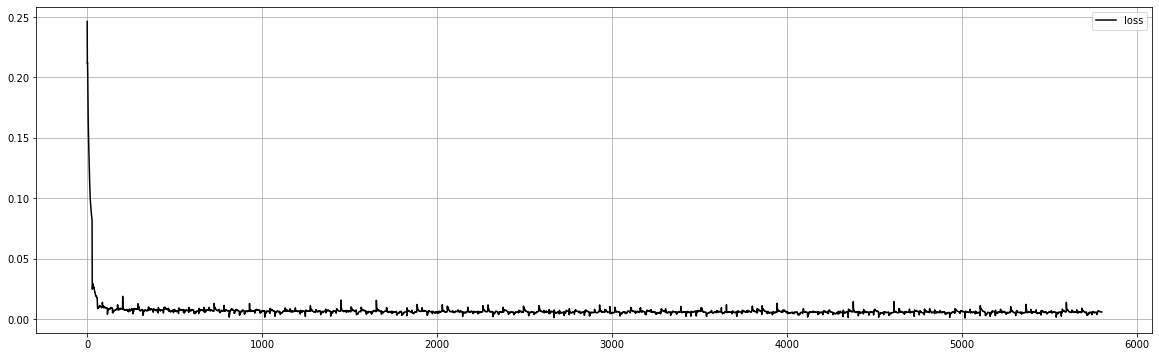

In [43]:
# Visualising the loss
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = history.losses
ax.plot(x, color = 'black', label = 'loss')
ax.legend()
ax.grid(True)
plt.show()

In [44]:
from tensorflow.keras.models import load_model
best_model = load_model('./串联/22.05_86_men_4_lstm_2_dense_1_unit_52')

predicted_train = best_model.predict(x_train)
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = best_model.predict(x_test)
predicted_test = scaler.inverse_transform(predicted_test)
real_train=scaler.inverse_transform(np.reshape(y_train,(-1,1)))
real_test=scaler.inverse_transform(np.reshape(y_test,(-1,1)))

best_model.summary()
best_model.evaluate(x_test,y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 52)                11440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 52)                2756      
_________________________________________________________________
dropout_3 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 53        
Total params: 14,249
Trainable params: 14,249
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.0045 - mape: 22.0479


[0.00446223933249712, 22.04789924621582]

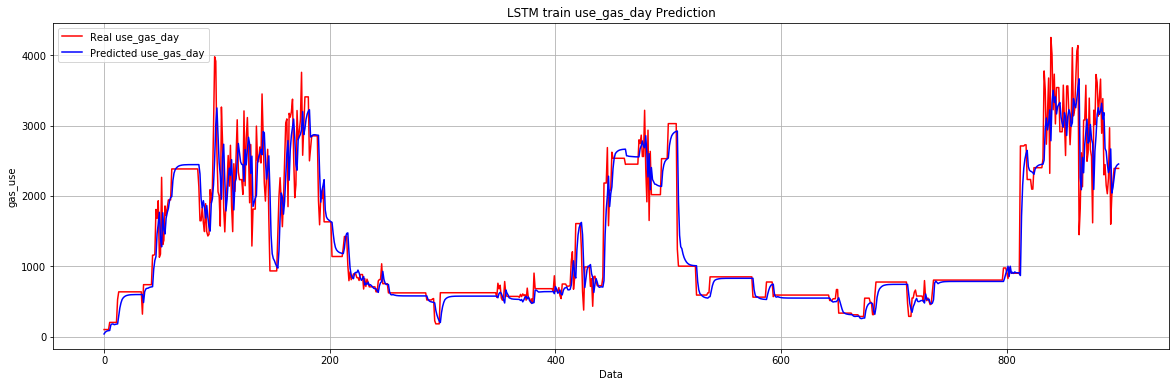

train_mean: 1302.100167
LSTM模型的均方误差是: 95103.011236
LSTM模型的均方根误差是: 308.387761
LSTM模型的平均绝对误差是: 168.713023
LSTM模型的R-squared是: 0.891465


In [45]:
# Visualising the train results
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = date_list[:900]
ax.plot(real_train, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_train, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM train use_gas_day Prediction')
ax.set_xlabel('Data')
ax.set_ylabel('gas_use')
ax.legend()
ax.grid(True)
plt.show()
############################################
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
train_mean = mean(real_train)
mse = mean_squared_error(real_train,predicted_train)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(real_train,predicted_train))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(real_train,predicted_train)

r2=r2_score(real_train,predicted_train)

print('train_mean: %.6f' % train_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)

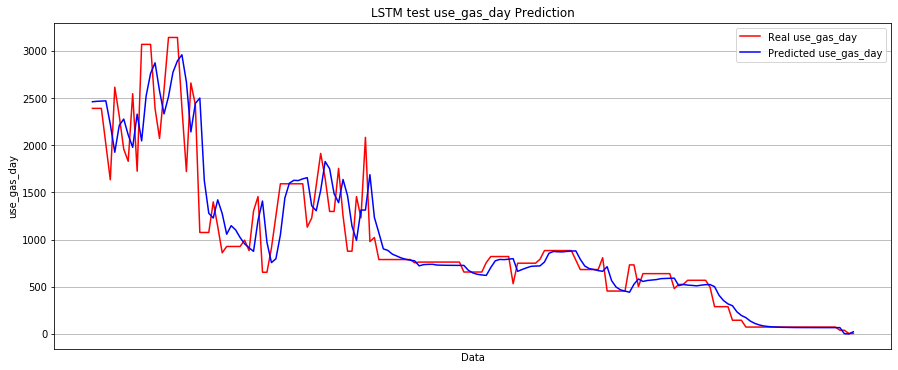

test_mean: 959.823138
LSTM模型的均方误差是: 80622.924015
LSTM模型的均方根误差是: 283.941762
LSTM模型的平均绝对误差是: 168.553997
LSTM模型的R-squared是: 0.856480


In [46]:
# Visualising the test results
import matplotlib.dates as mdates
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
x = date_list[900:]
ax.plot(real_test, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_test, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM test use_gas_day Prediction')
ax.set_xlabel('Data')
ax.set_ylabel('use_gas_day')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
ax.grid(True)
plt.show()
###################################
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
test_mean = mean(real_test)
mse = mean_squared_error(real_test,predicted_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(real_test,predicted_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_test, real_test)

r2=r2_score(real_test,predicted_test)
acc = (test_mean-mae)/test_mean
print('test_mean: %.6f' % test_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)